# Neural Networks as Universal Function Approximators

[The universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem) states that a feed-forward neural network with a single hidden layer containing a finite number of neurons can approximate any continuous function (provided some assumptions on the activation function are met) to an arbitrary precision [1]. If the function jumps around or has large gaps, we won't be able to approximate it.


We create an example neural network as a function approximator for a policy function, which solves a model equation. 

As a starting point we use our model to approximate 

$$f(x) = 0.2+0.4x^2 + 0.3x*sin(15x)+0.05*cos(50x)$$ 

in the interval $[0, 1]$ with a neural network having 1 hidden layers with 100 neurons.

We  measure precisions uusing the mean squared error `log10`.

In [1]:
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (0, lim)

class neural_net(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, num_states, hidden_size, num_policies, dropout):
        """Initialize parameters and build model.

        Params
        ======
            num_states (int): Number of states
            num_policies (int): Number of policies
            hidden_size (int): Number of nodes in first hidden layer, sequential ones will have proportionally less
        """
        # Neural net has input, output, and two hidden layers
        super(neural_net, self).__init__()
        self.input_layer = nn.Linear(num_states, hidden_size)
 
        self.dropout_layer = nn.Dropout(p=dropout)
        self.output_layer = nn.Linear(hidden_size, num_policies)
        self.cuda()

    def forward(self, state):
        x = F.relu(self.input_layer(state))
        out = self.output_layer(x)
        return out

In [2]:
device = "cuda"
def ten(x): return torch.from_numpy(x).float().to(device)


def numpize(cuda_tensor):
    return cuda_tensor.cpu().detach().numpy()

class approx():
   
  def __init__(self, grid, n_neurons:int=100, lr:float = 0.0005):
      # self.grid_min =  1.07312 
      # self.grid_max = 20.38941
      self.grid = grid
      self.n_neurons = n_neurons
      self.grid = ten(grid).unsqueeze(1)
      self.lr = lr

      self.policy_net = neural_net(1, self.n_neurons, 1, 0.0001)
      self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
                  
  def train(self):
      policy = self.policy_net(self.grid)
      criterion = torch.nn.MSELoss()
      policy.cuda()

      for episode in range(30000):
          policy = self.policy_net(self.grid)

          self.optimizer.zero_grad()
          loss = criterion(policy, self.grid)
          # loss = ((policy-self.grid)**2).mean()

          if episode % 1000 == 0:
              mean_loss = loss.squeeze().cpu().detach().item()
              losslog10 = math.log10(math.sqrt(loss.squeeze().cpu().detach().item()))
              print('episode {} -- loss : {:8.9f}-- losslog10 : {:8.6f}'.format(episode, mean_loss, losslog10))
          loss.backward()
          self.optimizer.step()
      return numpize(policy.squeeze())

In [3]:
grid_min =  0 
grid_max = 1
x = np.linspace(grid_min,grid_max,1000)
y = 0.2+0.4*x**2 + 0.3*x*np.sin(15*x)+0.05*np.cos(50*x)

approxlin = approx(y, 10, 0.0005)
h = approxlin.train()

episode 0 -- loss : 0.253625810-- losslog10 : -0.297903
episode 1000 -- loss : 0.001647251-- losslog10 : -1.391620
episode 2000 -- loss : 0.000007348-- losslog10 : -2.566914
episode 3000 -- loss : 0.000000517-- losslog10 : -3.143333
episode 4000 -- loss : 0.000000037-- losslog10 : -3.716396
episode 5000 -- loss : 0.000000003-- losslog10 : -4.281625
episode 6000 -- loss : 0.000000000-- losslog10 : -4.840607
episode 7000 -- loss : 0.000000000-- losslog10 : -5.384723
episode 8000 -- loss : 0.000000000-- losslog10 : -5.887729
episode 9000 -- loss : 0.000000000-- losslog10 : -6.202014
episode 10000 -- loss : 0.000000000-- losslog10 : -6.604547
episode 11000 -- loss : 0.000000000-- losslog10 : -7.172984
episode 12000 -- loss : 0.000000000-- losslog10 : -7.506167
episode 13000 -- loss : 0.000000000-- losslog10 : -7.543414
episode 14000 -- loss : 0.000000000-- losslog10 : -6.067981
episode 15000 -- loss : 0.000000000-- losslog10 : -6.767457
episode 16000 -- loss : 0.000000000-- losslog10 : -5.

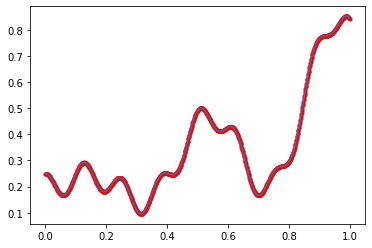

In [7]:
plt.plot(x,h)
plt.scatter(x, h, color='red', s=10)

#### References
[1] Cybenko, G. (1989). "Approximation by superpositions of a sigmoidal function". Mathematics of Control, Signals, and Systems. 2 (4): 303–314. CiteSeerX 10.1.1.441.7873. doi:10.1007/BF02551274. S2CID 3958369